# Solving the Fallout Terminal Hacking Minigame
- See https://www.owenmc.dev/posts/fallout-terminal for a blog post with more details

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
import random
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial import Delaunay
from itertools import permutations

### Importing Words
- https://github.com/dwyl/english-words/tree/master

In [3]:
word_lengths = defaultdict(list)

with open('words_alpha.txt', 'r') as words:
    for word in words.read().split():
        word_lengths[len(word)].append(word)

### Computing Likeness

In [4]:
def get_likeness(word_a, word_b):
    likeness = 0
    for i in range(len(word_a)):
        if word_a[i] == word_b[i]:
            likeness += 1
    return likeness

In [5]:
def get_likeness(word_a, word_b):
    return sum([1 for i, chars in enumerate(zip(word_a, word_b)) if chars[0] == chars[1]])

In [6]:
get_likeness("rowing", "flying")

3

### Algorithm to Maximize Eliminations

In [7]:
sample = ['swamp', 'drape', 'water', 'swish', 'again']

In [8]:
def maximize_eliminations(words):
    word_scores = {word: {i: 0 for i in range(len(words[0]))} for word in words}
    word_sums = word_sums = {word: 0 for word in words}

    for perm in permutations(words, 2):
        outer_word, inner_word = perm
        for i in range(len(words[0])):
            if outer_word[i] == inner_word[i]:
                word_scores[outer_word][i] += 1
                word_sums[outer_word] += 1


    return max(word_sums, key=lambda x: word_sums[x])

In [10]:
%time maximize_eliminations(sample)

CPU times: user 34 µs, sys: 15 µs, total: 49 µs
Wall time: 53.4 µs


'swamp'

In [11]:
sample = random.sample(word_lengths[5], 10000)
%time maximize_eliminations(sample)

CPU times: user 59.8 s, sys: 5.06 ms, total: 59.8 s
Wall time: 59.8 s


'sales'

### Terminal Hacking Game Class

In [42]:
class Game:
    def __init__(self, strategy, word_length, word_count, log=True):
        self.words = random.sample(word_lengths[word_length], word_count)
        self.eligible_words = self.words
        self.unique_char_map = {i: [] for i in range(1, 6)}
        self.yellow_positions = {i: set() for i in range(5)}
        self.word = random.sample(self.words, 1)[0]
        self.strategy = strategy
        self.likeness_map = {}
        self.solved = False
        self.log=log
        
    def summarize(self):
        print(self.eligible_words)
        print(self.likeness_map)
        print(len(self.likeness_map))
        print(len(self.eligible_words))
        
    def get_likeness(self, guess):
        likeness = 0
        for i in range(len(guess)):
            if self.word[i] == guess[i]:
                likeness += 1
        return likeness
    
    def get_possible_likeness(self, word_a, word_b):
        possible_likeness = 0
        for i in range(len(word_a)):
            if word_a[i] == word_b[i]:
                possible_likeness += 1
        return possible_likeness
    
    def guess(self, guess):
        likeness = self.get_likeness(guess)
        self.likeness_map[guess] = likeness
        if likeness == len(guess):
            self.solved = True
            
    def maximize_eliminations(self):
        words = self.eligible_words
        word_scores = {word: {i: 0 for i in range(len(words[0]))} for word in words}
        word_sums = word_sums = {word: 0 for word in words}

        for perm in permutations(words, 2):
            outer_word, inner_word = perm
            for i in range(len(words[0])):
                if outer_word[i] == inner_word[i]:
                    word_scores[outer_word][i] += 1
                    word_sums[outer_word] += 1


        return max(word_sums, key=lambda x: word_sums[x])
                    
    def random_guess(self):
        return random.choice(list(self.eligible_words))
    
    def update_eligible_words(self):
        eligible = set()
        for word in self.eligible_words:
            for guess in self.likeness_map:
                possible_likeness = self.get_possible_likeness(guess, word)
                if possible_likeness == self.likeness_map[guess]:
                    eligible.add(word)
                else:
                    if word in eligible:
                        eligible.remove(word)
        self.eligible_words = list(eligible)
    
    def play(self):
        solved = False
        while not solved:
            if self.strategy == 'random':
                guess = self.random_guess()
            if self.strategy == 'maximize_eliminations':
                guess = self.maximize_eliminations()
            self.guess(guess)
            if self.log:
                self.summarize()
            self.update_eligible_words()
            if self.solved:
                solved = True
        return len(self.likeness_map)

### Run Simulations and Aggregate Performance Stats

In [71]:
def simulate(strategy, trials, word_length, word_count, plot=True):
    guesses = []
    for i in range(trials):
        g = Game(strategy, word_length, word_count, log=False)
        guesses.append(g.play())
        
    average_guesses = sum(guesses) / len(guesses)
    four_or_fewer = 0
    
    for guess in guesses:
        if guess <= 4:
            four_or_fewer += 1
            
    four_or_fewer_percentage = four_or_fewer / len(guesses)
    
    if plot:
        data = Counter(sorted(guesses))
        plt.figure(figsize=(8, 6))
        print({i[0] : i[1] for i in sorted(data.items(), key=itemgetter(0))})
        keys = list(data.keys())
        values = list(data.values())
        x_pos = range(len(keys))
        plt.bar(x_pos, values)
        plt.xticks(x_pos, keys)
        plt.show()
        
    return average_guesses, four_or_fewer_percentage

{1: 505, 2: 1300, 3: 2349, 4: 2648, 5: 2035, 6: 900, 7: 228, 8: 31, 9: 3, 10: 1}


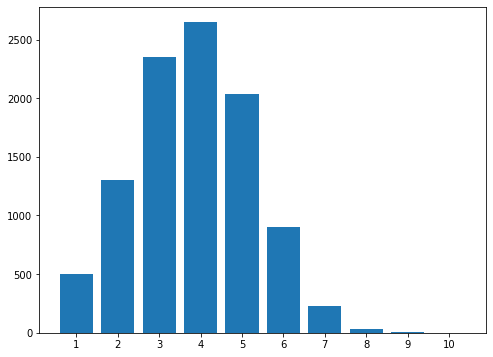

(3.82, 0.6802)

In [72]:
simulate('random', 10000, 5, 20)

{1: 551, 2: 1636, 3: 3151, 4: 3203, 5: 1295, 6: 152, 7: 12}


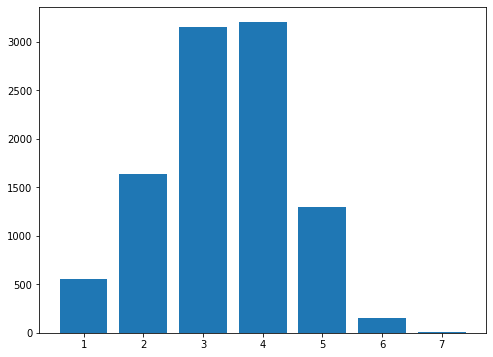

(3.3559, 0.8541)

In [73]:
simulate('maximize_eliminations', 10000, 5, 20)

### Compare Performance for Different Word Lengths / Counts and Plot Results

In [21]:
def compare(num_trials, lengths, counts):
    random_avg = []
    random_pcts = []

    optimized_avg = []
    optimized_pcts = []
    
    for length, count in zip(lengths, counts):
        random_avg_guesses, random_pct = simulate('random', num_trials, length, count, plot=False)
        optimized_avg_guesses, optimized_pct = simulate('maximize_eliminations', num_trials, length, count, plot=False)

        random_avg.append(random_avg_guesses)
        random_pcts.append(random_pct)

        optimized_avg.append(optimized_avg_guesses)
        optimized_pcts.append(optimized_pct)
        
    return random_avg, optimized_avg, random_pcts, optimized_pcts

In [59]:
def plot_results(random, optimized, x_axis, x_axis_label, y_axis_label):
    plt.figure(figsize=(8, 6))
    plt.plot(x_axis, random, label='Random Strategy', color='blue')
    plt.plot(x_axis, optimized, label='Optimized Strategy', color='orange')
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

In [74]:
lengths = [i for i in range(5,15)]
counts = [20 for i in range(len(lengths))] # fixed at 20

random_avg, optimized_avg, random_pcts, optimized_pcts = compare(1000, lengths, counts)

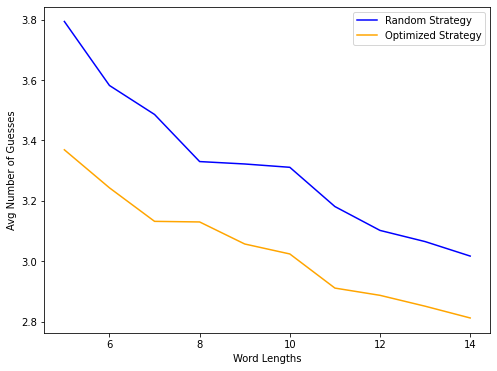

In [75]:
plot_results(random_avg, optimized_avg, lengths, 'Word Lengths', 'Avg Number of Guesses')

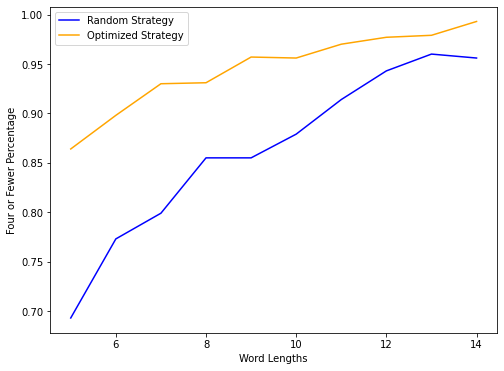

In [76]:
plot_results(random_pcts, optimized_pcts, lengths, 'Word Lengths', 'Four or Fewer Percentage')

In [82]:
counts = [i for i in range(5, 20)]
lengths = [5 for i in range(len(counts))] # fixed at 5

random_avg, optimized_avg, random_pcts, optimized_pcts = compare(1000, lengths, counts)

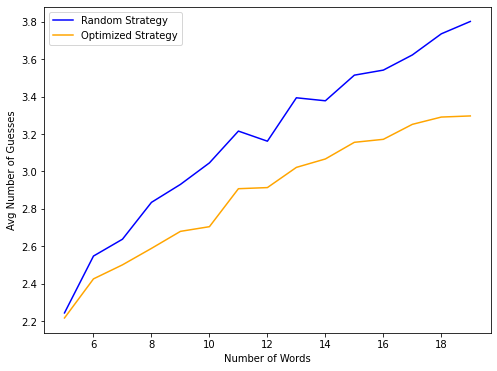

In [83]:
plot_results(random_avg, optimized_avg, counts, 'Number of Words', 'Avg Number of Guesses')

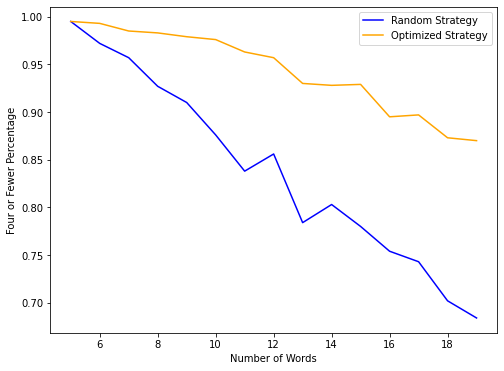

In [84]:
plot_results(random_pcts, optimized_pcts, counts, 'Number of Words', 'Four or Fewer Percentage')

### Plot Performance on 3d Graph

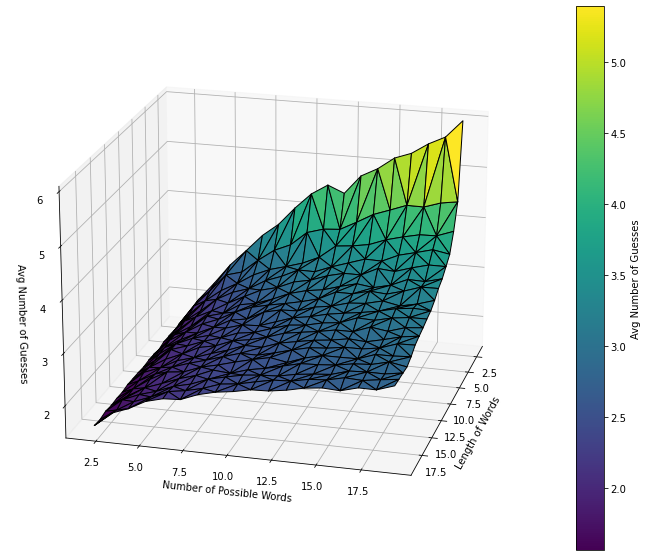

In [354]:
lengths = []
counts = []
averages = []
percentages = []

for i in range(2,20):
    for j in range(2,20):
        lengths.append(i)
        counts.append(j)
        avg, pct = simulate('random', 1000, i, j, plot=False)
        averages.append(avg)
        percentages.append(pct)
        
x_data = lengths
y_data = counts
z_data = averages

triangulation = Delaunay(np.array([x_data, y_data]).T)

# Create a larger 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the filled surface
surf = ax.plot_trisurf(x_data, y_data, z_data, triangles=triangulation.simplices, cmap='viridis', edgecolor='k')

# Set axis labels
ax.set_xlabel('Length of Words')
ax.set_ylabel('Number of Possible Words')
ax.set_zlabel('Avg Number of Guesses')

# Add a colorbar
fig.colorbar(surf, ax=ax, label='Avg Number of Guesses')

# Allow rotation and zooming
ax.view_init(elev=20, azim=15)  # Initial view angle
plt.show()

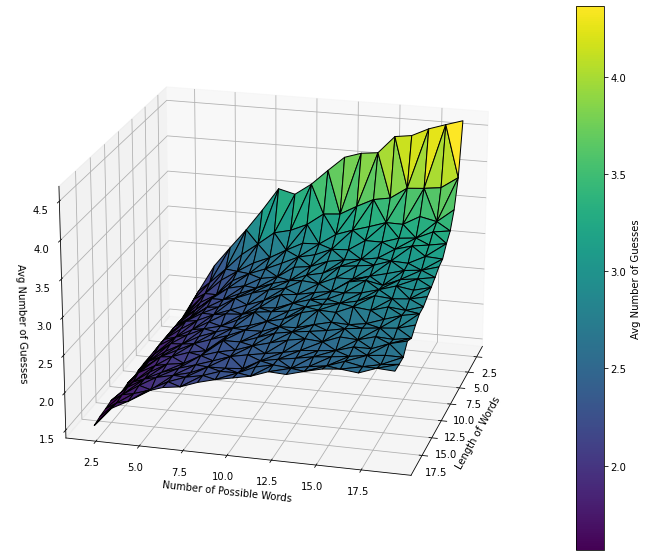

In [85]:
lengths = []
counts = []
averages = []
percentages = []

for i in range(2,20):
    for j in range(2,20):
        lengths.append(i)
        counts.append(j)
        avg, pct = simulate('maximize_eliminations', 1000, i, j, plot=False)
        averages.append(avg)
        percentages.append(pct)
        
x_data = lengths
y_data = counts
z_data = averages

triangulation = Delaunay(np.array([x_data, y_data]).T)

# Create a larger 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the filled surface
surf = ax.plot_trisurf(x_data, y_data, z_data, triangles=triangulation.simplices, cmap='viridis', edgecolor='k')

# Set axis labels
ax.set_xlabel('Length of Words')
ax.set_ylabel('Number of Possible Words')
ax.set_zlabel('Avg Number of Guesses')

# Add a colorbar
fig.colorbar(surf, ax=ax, label='Avg Number of Guesses')

# Allow rotation and zooming
ax.view_init(elev=20, azim=15)  # Initial view angle
plt.show()

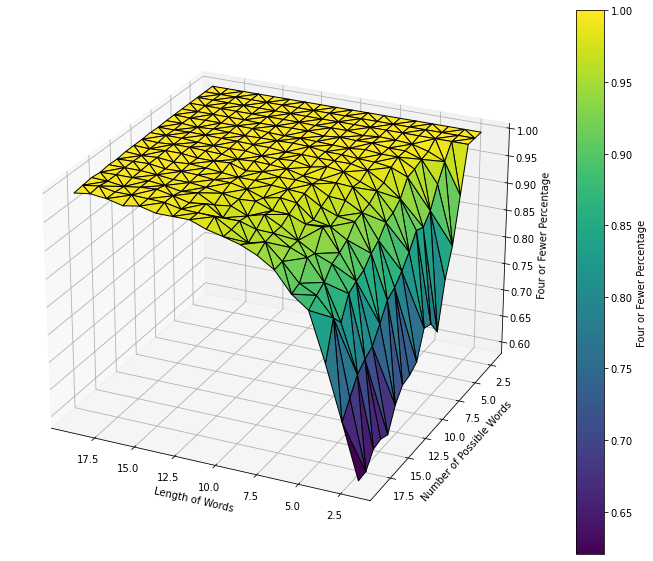

In [86]:
z_data = percentages

triangulation = Delaunay(np.array([x_data, y_data]).T)

# Create a larger 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the filled surface
surf = ax.plot_trisurf(x_data, y_data, z_data, triangles=triangulation.simplices, cmap='viridis', edgecolor='k')

# Set axis labels
ax.set_xlabel('Length of Words')
ax.set_ylabel('Number of Possible Words')
ax.set_zlabel('Four or Fewer Percentage')

# Add a colorbar
fig.colorbar(surf, ax=ax, label='Four or Fewer Percentage')

# Allow rotation and zooming
ax.view_init(elev=25, azim=115)  # Initial view angle
plt.show()
